In [2]:
# import warnings filter
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)

In [3]:
import pandas as pd
import numpy as np
import re
import nltk
df = pd.read_csv('C:\\Ashish\\Project\\dataset\\trainset1.csv')#,nrows = 1500)

In [4]:
def remove_pattern(input_txt, pattern):
    r = re.findall(pattern, input_txt)
    for i in r:
        input_txt = re.sub(i, '', input_txt)
        
    return input_txt  

# remove twitter handles (@user)
df['text'] = np.vectorize(remove_pattern)(df['text'], "@[\w]*")

#TO DO - REMOVE ASCII EXTENDED
for i in range(len(df)):
    tweet = df.iloc[i,df.columns.get_loc('text')]
    tweet = tweet.lower()
    tweet = re.sub(r"\S+\/.\S+ *\S+|.\S+html|\S+-\S+|\d*\/\d+|\d+|\S+%\S+|\S+:\S*|\S+=\S+|.#\S+", "", tweet)
    tweet = tweet.encode("ascii", errors="ignore").decode()
    df.iloc[i,df.columns.get_loc('text')] = tweet
    
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize 
stop_words = set(stopwords.words('english'))
for i in range(len(df)):
    tweet = df.iloc[i,df.columns.get_loc('text')]
    word_tokens = word_tokenize(tweet) 
    filtered_sentence = [w for w in word_tokens if not w in stop_words] 
    filtered_sentence = [] 
    for w in word_tokens: 
        if w not in stop_words: 
            filtered_sentence.append(w) 
    tweet = ' '.join(filtered_sentence)
    df.iloc[i,df.columns.get_loc('text')] = tweet
    
custom_words = ['via','rt','fav','…','am','et','pm','n\'t','y\'all']
for i in range(len(df)):
    tweet = df.iloc[i,df.columns.get_loc('text')]
    querywords = tweet.split()
    resultwords  = [word for word in querywords if word.lower() not in custom_words]
    result = ' '.join(resultwords)
    df.iloc[i,df.columns.get_loc('text')] = result

import string
remove = string.punctuation + ".‘’\''“”°…-—––•・®.:#"
for i in range(len(df)):
    tweet = df.iloc[i,df.columns.get_loc('text')]
    tweet = ' '.join(word.strip(remove) for word in tweet.split())
    tweet = tweet.strip()
    df.iloc[i,df.columns.get_loc('text')] = tweet

# Lemmatize with POS Tag
from nltk.corpus import wordnet
from nltk.stem.wordnet import WordNetLemmatizer

def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)

# 1. Init Lemmatizer
lemmatizer = WordNetLemmatizer()

for i in range(len(df)):
    tweet = df.iloc[i,df.columns.get_loc('text')]
    tweet =([lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in nltk.word_tokenize(tweet)])
    tweet = ' '.join(tweet)
    df.iloc[i,df.columns.get_loc('text')] = tweet

# REVIEW NEEDED
import nltk
words = set(nltk.corpus.words.words())
for i in range(len(df)):
    tweet = df.iloc[i,df.columns.get_loc('text')]
    tweet = ' '.join(word for word in tweet.split() if len(word)>3)
    df.iloc[i,df.columns.get_loc('text')] = tweet

In [5]:
df2 = df[['text','category']]

df2 = df2[pd.notnull(df2['text'])]

df2['category_id'] = df2['category'].factorize()[0]
category_id_df = df2[['category', 'category_id']].drop_duplicates().sort_values('category_id')
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category_id', 'category']].values)

In [110]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(sublinear_tf=True, min_df=3, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english')

features = tfidf.fit_transform(df2.text).toarray()
labels = df2.category_id

from sklearn.feature_selection import chi2

N = 2
for category, category_id in sorted(category_to_id.items()):
  features_chi2 = chi2(features, labels == category_id)
  indices = np.argsort(features_chi2[0])
  feature_names = np.array(tfidf.get_feature_names())[indices]
  unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
  bigrams = [v for v in feature_names if len(v.split(' ')) == 2]

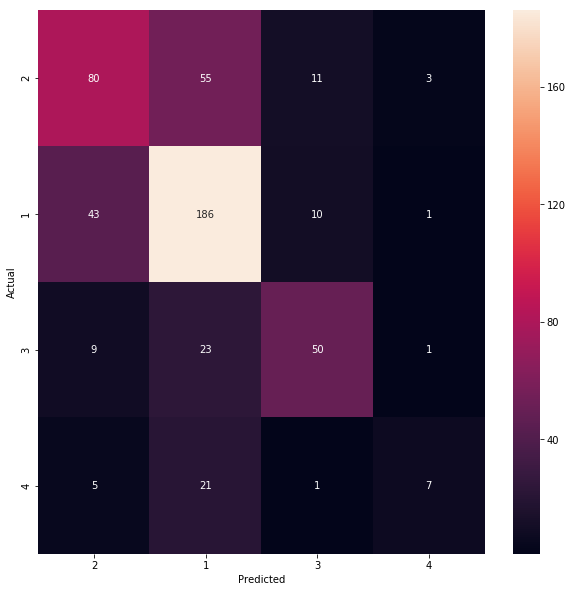

In [111]:
model = LinearSVC(random_state=0)

X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, df.index, test_size=0.25, random_state=0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

from sklearn.metrics import confusion_matrix

conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=category_id_df.category.values, yticklabels=category_id_df.category.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()